# Import

In [36]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from PIL import Image


# Constants and configuration

In [40]:
TRAIN_DATA_DIR = "datasets/Rock-Paper-Scissors/train"
VAL_DATA_DIR = "datasets/Rock-Paper-Scissors/test"

# Hyperparameters
IMG_SIZE = 128
BATCH_SIZE = 32
VAL_SPLIT = 0.2 # 20% for validation

# Transformations and dataset preparation

In [41]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats (good default)
        std=[0.229, 0.224, 0.225]
    ),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats (good default)
        std=[0.229, 0.224, 0.225]
    ),
])

In [43]:
train_dataset = datasets.ImageFolder(root=TRAIN_DATA_DIR, transform=train_transforms)
validation_dataset = datasets.ImageFolder(root=VAL_DATA_DIR, transform=val_transforms)

# Class names and mapping (folder names => indices)
class_names = train_dataset.classes      # ['paper', 'rock', 'scissors']
class_to_idx = train_dataset.class_to_idx    # {'paper': 0, 'rock': 1, 'scissors': 2}
print("Classes", class_names)

Classes ['paper', 'rock', 'scissors']


# Data loaders

In [44]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Show datasets

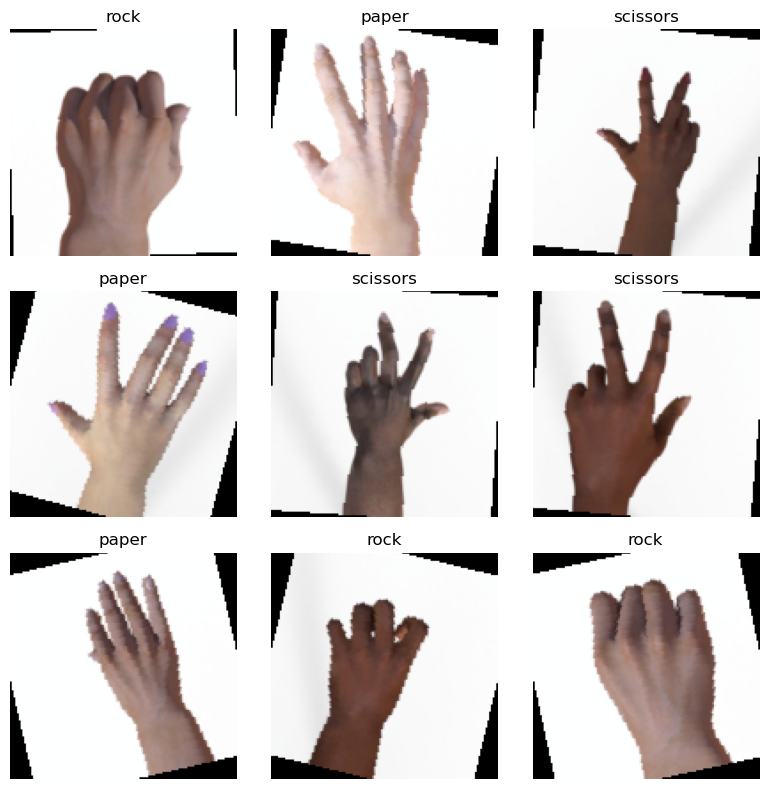

In [45]:
# Helper to undo normalization for visualization
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Get one batch
images, labels = next(iter(train_loader))

NUM_IMG = 9
plt.figure(figsize=(8, 8))

for i in range(NUM_IMG):
    ax = plt.subplot(3, 3, i + 1)
    img = denormalize(images[i])
    plt.imshow(img)
    label_idx = labels[i].item()
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Define model

In [46]:
NUM_CLASSES = len(class_names)

class RockPaperScissorsCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # 3 x 128 x 128 -> conv blocks -> flatten -> FC
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 3 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 128 -> 64
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 32 -> 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 64 -> 32
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # 64 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 32 -> 16
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),    # 128 -> 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2), # 16 -> 8
        )

        # After 3 poolings : 3 x 128 x 128 -> 256 x 8 x 8
        self.flatten_dim = 256 * 8 * 8

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # logits for each class
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc(x)
        return x

# Instantiate model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RockPaperScissorsCNN().to(DEVICE)
model


RockPaperScissorsCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 

# Model training

In [47]:
# Training configuration
EPOCHS = 15
LEARNING_RATE = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float("inf")
BEST_MODEL_PATH = "models/model.pt"

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch} / {EPOCHS} [Train]", leave=False)
    
    for images, labels in train_pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total

    # ---- VALIDATION ----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # ---- Save the best model (lowest validation loss) ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        saved_flag = " [saved best]"
    else:
        saved_flag = ""
    
    print(
        f"Epoch {epoch:02d} / {EPOCHS} "
        f"- train loss: {train_loss:.4f}, train_acc: {train_acc:.4f} "
        f"- val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f} {saved_flag}"
    )

print(f"\nBest validation loss: {best_val_loss:.4f}")

Epoch 1 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 01 / 15 - train loss: 1.5780, train_acc: 0.5579 - val_loss: 0.4487, val_acc: 0.8280  [saved best]


Epoch 2 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 02 / 15 - train loss: 0.1711, train_acc: 0.9456 - val_loss: 0.2426, val_acc: 0.9194  [saved best]


Epoch 3 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 03 / 15 - train loss: 0.0749, train_acc: 0.9750 - val_loss: 0.1459, val_acc: 0.9435  [saved best]


Epoch 4 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 04 / 15 - train loss: 0.0519, train_acc: 0.9833 - val_loss: 0.6541, val_acc: 0.7903 


Epoch 5 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 05 / 15 - train loss: 0.0519, train_acc: 0.9817 - val_loss: 0.1508, val_acc: 0.9435 


Epoch 6 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 06 / 15 - train loss: 0.0554, train_acc: 0.9802 - val_loss: 0.1880, val_acc: 0.9301 


Epoch 7 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 07 / 15 - train loss: 0.0542, train_acc: 0.9794 - val_loss: 0.4064, val_acc: 0.8952 


Epoch 8 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 08 / 15 - train loss: 0.0616, train_acc: 0.9754 - val_loss: 0.1018, val_acc: 0.9516  [saved best]


Epoch 9 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 09 / 15 - train loss: 0.0274, train_acc: 0.9897 - val_loss: 0.5587, val_acc: 0.8441 


Epoch 10 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10 / 15 - train loss: 0.0393, train_acc: 0.9849 - val_loss: 0.0619, val_acc: 0.9758  [saved best]


Epoch 11 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11 / 15 - train loss: 0.0371, train_acc: 0.9849 - val_loss: 0.2571, val_acc: 0.9247 


Epoch 12 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12 / 15 - train loss: 0.0414, train_acc: 0.9861 - val_loss: 0.0614, val_acc: 0.9704  [saved best]


Epoch 13 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13 / 15 - train loss: 0.0367, train_acc: 0.9857 - val_loss: 0.6308, val_acc: 0.8710 


Epoch 14 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14 / 15 - train loss: 0.0221, train_acc: 0.9893 - val_loss: 0.1515, val_acc: 0.9355 


Epoch 15 / 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15 / 15 - train loss: 0.0386, train_acc: 0.9833 - val_loss: 0.5932, val_acc: 0.8333 

Best validation loss: 0.0614


# Inference and visualization

In [58]:
import glob

# 1) Load best model weights
inference_model = RockPaperScissorsCNN().to(DEVICE)
inference_model.load_state_dict(torch.load("models/model.pt", map_location=DEVICE))
inference_model.eval()

# 2) Single-image prediction helper
def predict_image(image_path):
    # load image
    img = Image.open(image_path).convert("RGB")
    
    # use SAME preprocessing as validation
    img_tensor = val_transforms(img)          # [C, H, W]
    img_tensor = img_tensor.unsqueeze(0)      # [1, C, H, W]
    img_tensor = img_tensor.to(DEVICE)

    with torch.no_grad():
        outputs = inference_model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)

    pred_class = class_names[pred_idx.item()]
    return pred_class, conf.item()

def predict_folder(folder_path):
    image_paths = []
    # add more extensions if needed
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))

    print(f"Found {len(image_paths)} images in {folder_path}")
    correct = 0
    total = 0

    for img_path in image_paths:
        pred_class, conf = predict_image(img_path)

        # infer true label from folder name (paper/rock/scissors)
        true_label_name = os.path.basename(os.path.dirname(img_path))
        is_correct = (pred_class == true_label_name)
        correct += int(is_correct)
        total += 1

    if total > 0:
        acc = correct / total
        print(f"\nAccuracy on folder '{folder_path}': {acc:.4f} ({correct}/{total})")
    else:
        print("No images found.")

# Example: run on a folder containing only rock images
test_folders = [
    "datasets/Rock-Paper-Scissors/test/paper",
    "datasets/Rock-Paper-Scissors/test/rock",
    "datasets/Rock-Paper-Scissors/test/scissors"
]

for folder in test_folders:
    predict_folder(folder)

Found 124 images in datasets/Rock-Paper-Scissors/test/paper

Accuracy on folder 'datasets/Rock-Paper-Scissors/test/paper': 0.9355 (116/124)
Found 124 images in datasets/Rock-Paper-Scissors/test/rock

Accuracy on folder 'datasets/Rock-Paper-Scissors/test/rock': 1.0000 (124/124)
Found 124 images in datasets/Rock-Paper-Scissors/test/scissors

Accuracy on folder 'datasets/Rock-Paper-Scissors/test/scissors': 0.9758 (121/124)
